In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import ast

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

ML_cup_train = pd.read_csv('../data/ML-CUP23-TR.csv', header=None, index_col=0, comment='#').sample(frac=1, random_state=RANDOM_STATE)
TR_INPUT = 10
TR_OUTPUT = 3
scaler_in = StandardScaler()
scaler_out = StandardScaler()
ML_cup_train_norm = ML_cup_train.values.copy()

ML_cup_train_norm[:,:TR_INPUT] = scaler_in.fit_transform(ML_cup_train_norm[:,:TR_INPUT])
ML_cup_train_norm[:,TR_INPUT:] = scaler_out.fit_transform(ML_cup_train_norm[:,TR_INPUT:])

training_len = len(ML_cup_train_norm)

In [3]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

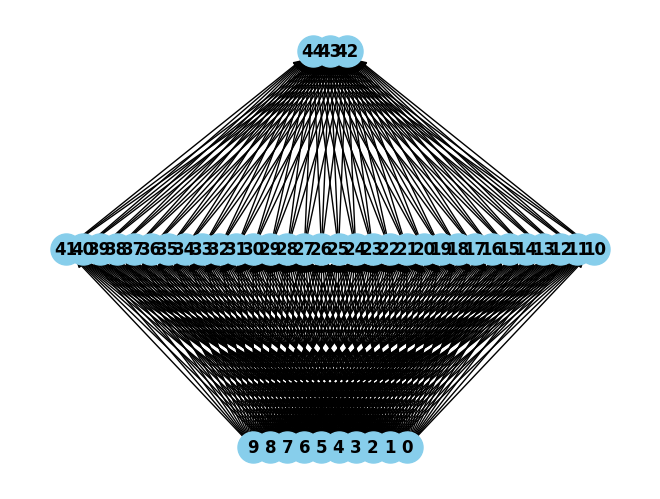

In [4]:
hidden_len = 32
hidden_fun = 'sigmoid'
output_fun = 'identity'
sigmoid_l1 = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)
NeuralNetwork.display_topology(sigmoid_l1)

In [5]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [6]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [7]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [8]:
results_files = ['bagging_model.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)

orig_df = pd.concat(gs_results)

In [9]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [10]:
gs_results = gs_results.apply(remove_useless_val, axis=1)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [11]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [12]:
orig_df

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,"{'adamax': False, 'exp_decay_rate_2': 0.999, '...",8,150,500,5,0.000001,1.000000e-09,0.11,0.85,200,False,0.098424,0.013096,0.000005,5.119440e-07,0.009886


In [13]:
gen = np.random.default_rng(seed=None)
def get_new_tr_vl(pattern_set, len_ds, gen):
    return gen.choice(pattern_set, len_ds)

In [14]:
n_models = 11
tr_len = 533
max_epochs = 500
mod = []

met = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ]
predictions_accumul_tr = np.zeros((max_epochs, training_len, TR_OUTPUT))

for i in range(n_models):
    
    tr = get_new_tr_vl(ML_cup_train_norm, 533, gen)
    NN = NeuralNetwork(sigmoid_l1, -0.75, 0.75, True, (i + 5977008))
    stats = NN.train(training_set = tr, 
                    validation_set = None, 
                    
                    batch_size= 8, 
                    max_epochs= max_epochs, 
                    min_epochs= 150,
                    retrainig_es_error = orig_df.iloc[0]['mean_best_validation_training_error'],
                    patience = 5, 
                    error_increase_tolerance = 0.000001, 
                    
                    lambda_tikhonov = 1.000000e-09, # off
                    
                    adamax = False,
                    
                    learning_rate = 0.11/8,
                    lr_decay_tau = 200, # off
                    eta_tau= (0.11/8)*0.01,
                    alpha_momentum = 0.85, # off
                    nesterov = False,
                    
                    metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ], 
                    collect_data=True, 
                    collect_data_batch=False, 
                    verbose=True,
                    
                    supp_dataset = ML_cup_train_norm)

        
    predictions_accumul_tr += np.array(stats['training_pred'] + 
                                            [stats['training_pred'][-1]]*(max_epochs - stats['epochs']))

    
    mod.append([NN, stats, tr])
    with open('../data/net/a2/model_' + str(i) + '.json', 'w+') as file:
            file.write(NN.toJSON())

starting values:  {'training_set_len': 533, 'minibatch_size': 8, 'max_epochs': 500, 'retrainig_es_error': 0.01087478308764089, 'error_increase_tolerance': 1e-06, 'patience': 5, 'min_epochs': 150, 'learning_rate': 0.01375, 'lr_decay_tau': 200, 'eta_tau': 0.0001375, 'lambda_tikhonov': 1e-09, 'alpha_momentum': 0.85, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.01, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999995), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_pred': [], 'validation_pred': [], 'training_mean_squared_error': [

[1/500] tr time: 0:00:01.234805 | mean_squared_error: tr=0.4517716896136052 val=-1 | | mean_euclidean_error: tr=0.5920898132562153 val=-1 | 
[2/500] tr time: 0:00:01.349640 | mean_squared_error: tr=0.11575831362055021 val=-1 | | mean_euclidean_error: tr=0.3073839364865771 val=-1 | 
[3/500] tr time: 0:00:01.106587 | mean_squared_error: tr=0.08342887733297724 val=-1 | | mean_euclidean_error: tr=0.26126435478126747 val=-1 | 
[4/500] tr time: 0:00:01.169370 | mean_squared_error: tr=0.07265237806032405 val=-1 | | mean_euclidean_error: tr=0.24418424777363051 val=-1 | 
[5/500] tr time: 0:00:01.170653 | mean_squared_error: tr=0.05790828464594381 val=-1 | | mean_euclidean_error: tr=0.21426383094798057 val=-1 | 
[6/500] tr time: 0:00:01.232213 | mean_squared_error: tr=0.05151168594134215 val=-1 | | mean_euclidean_error: tr=0.20205017699288286 val=-1 | 
[7/500] tr time: 0:00:01.532353 | mean_squared_error: tr=0.05524294772327908 val=-1 | | mean_euclidean_error: tr=0.2154431234016601 val=-1 | 
[8/

In [15]:
def construct_obj(list_mod):
    interesting_model = []
    for i in range(len(list_mod)):
        
        dummy = {}
        dummy['nn_file_name'] = '../data/net/a2/model_' + str(i) + '.json'
        dummy['index'] = i
        dummy['model'] = list_mod[i][0]
        dummy['stats'] = list_mod[i][1]
        dummy['top_name'] = '32_sigmoid'
        
        dummy['std_prediction_tr'] = dummy['model'].predict_array(list_mod[i][2][:,:TR_INPUT])      
        dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
        dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], list_mod[i][2][:,TR_INPUT:])
             
        dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], scaler_out.inverse_transform(list_mod[i][2][:,TR_INPUT:]))
        interesting_model.append(dummy)
        
    return interesting_model

In [16]:
models_list = construct_obj(mod)

In [17]:
with open('../data/net/a2/models.json', 'w+') as file:
    save_obj(models_list, file)

In [18]:
with open('../data/net/a2/ens_curves_tr.json', 'w+') as file:
    file.write(json.dumps(predictions_accumul_tr.tolist()))